# <center><ins>REIT Time Series Analysis(Ticker:RHP)<ins/><center/>

In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg

import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

In [3]:
RHP = web.DataReader('RHP', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
RHP = RHP.copy()
RHP.to_csv('data/RHP_GRU.csv')
RHP.index = pd.to_datetime(RHP.index)
RHP = RHP.resample('MS').mean()
RHP['mid'] = (RHP['high']+RHP['low'])/2
RHP.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

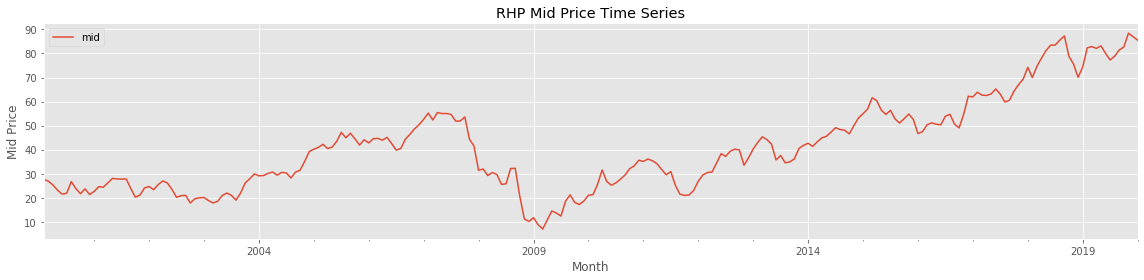

In [4]:
plt.style.use('ggplot')
RHP.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('RHP Mid Price Time Series')
plt.tight_layout()
plt.show();

## <ins>Time Series Decomposition<ins/>

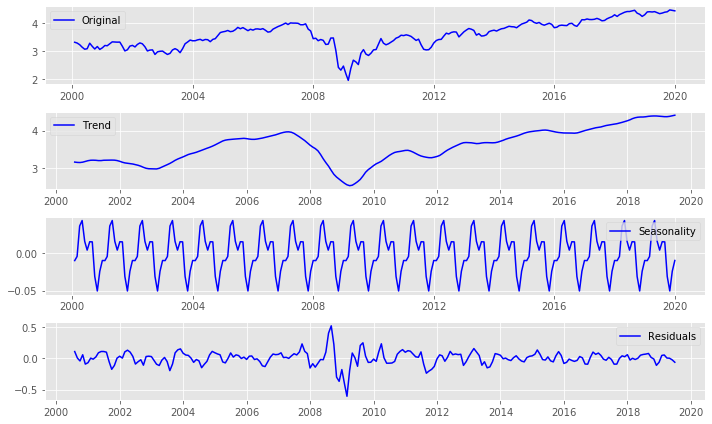

In [5]:
decomposition(RHP)

In [6]:
RHP_diff = RHP.diff(periods = 1).dropna()

In [7]:
dickey_fuller(RHP_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 5.948502272426395e-20


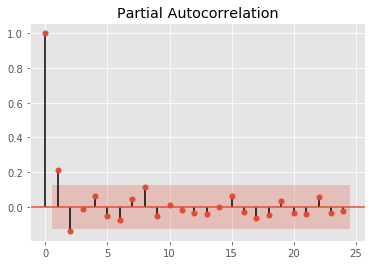

In [8]:
plot_pacf(RHP_diff);

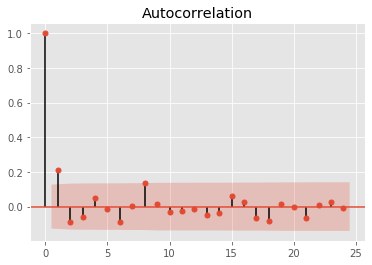

In [9]:
plot_acf(RHP_diff);

In [10]:
parameters = (2,1,5)
seasonal_parameters = (2,1,5,12)

In [11]:
RHP_train = RHP[:'2017']
RHP_test = RHP['2018':]

## <ins>SARIMAX Model w/o Exogenous Variables<ins/>

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -339.836
Date:                            Mon, 10 Feb 2020   AIC                            711.672
Time:                                    17:46:02   BIC                            758.274
Sample:                                02-01-2000   HQIC                           730.610
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0014      0.002      0.769      0.442      -0.002       0.005
ar.L1          0.2341     

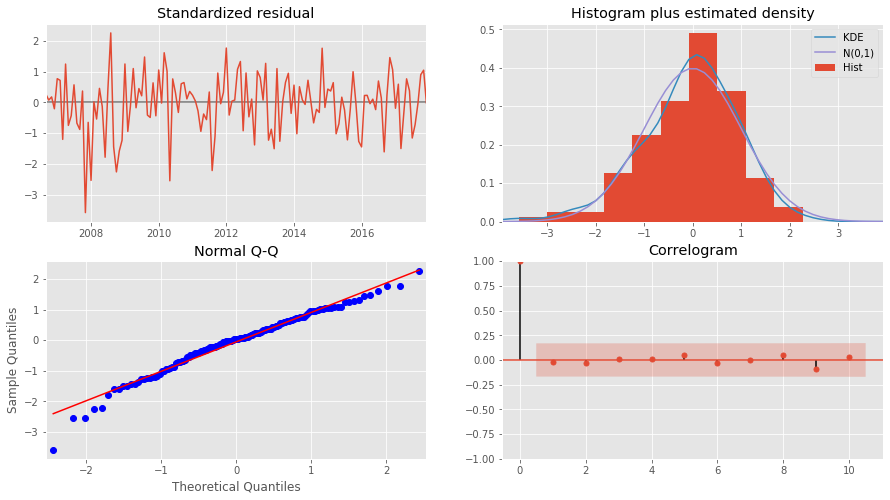

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


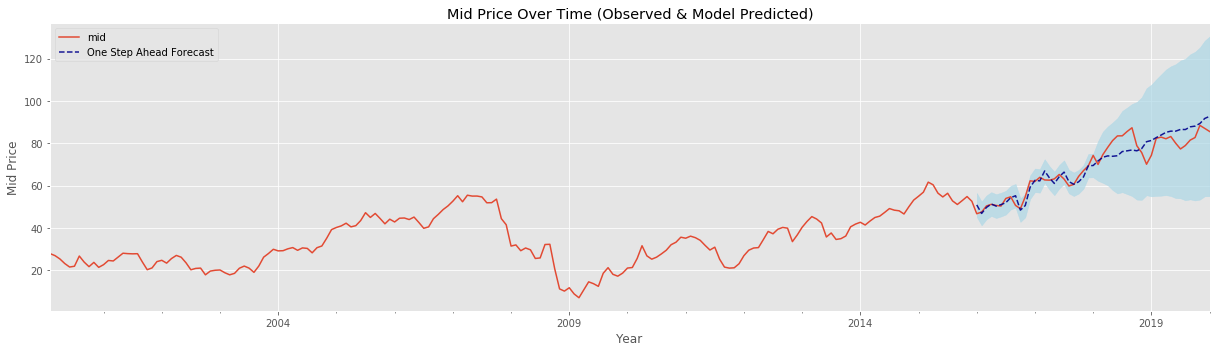

In [32]:
arima_endog(RHP_train, RHP,  parameters, seasonal_parameters)

## Gather Exogenous Variables

In [33]:
RHP_rates = pd.read_csv('data/RHP_rates.csv', index_col = 'date')

### Train Test Split Exogenous Variables

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.9759463850237745

usd1mtd156n       0.000000
mortgage30us     -0.000000
mortgage15us     -0.000000
dcpf3m            0.000000
cpn3m             0.644750
dcpf1m            0.000000
aaa              -0.000000
baa               0.000000
dff               0.000000
flexsc            0.000000
t10y2y           -2.536079
t10y3m           -0.000000
tedrate          -0.000000
t10yff           -0.000000
t5yff             0.000000
tb6smffm          0.000000
usd3mtd156n       0.000000
usd12md156n       0.000000
eur1wkd156n      -3.691066
mprime            0.000000
tb3ms             0.000000
dtb6              0.000000
dgs10             0.000000
dgs3mo            0.000000
dexuseu          -0.000000
dexchus           0.000000
dexusuk           0.000000
dexsius           0.000000
nasdaqcom        -0.006898
willreitind       0.004222
willlrgcap        0.001060
willsmlcap        0.000734
vxdcls            0.172349
stlfsi           -0.000000
nfci             -0.19

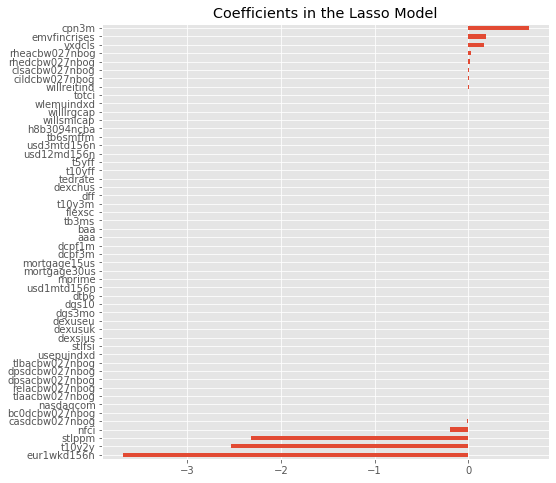

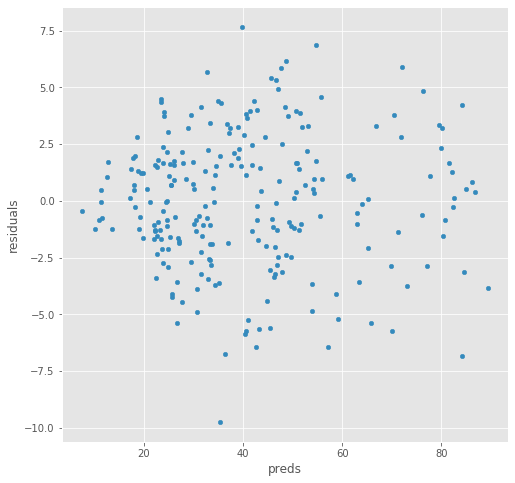

In [34]:
lasso_reg(RHP_rates)

### Select significant exogenous features from Lasso Regression

In [36]:
RHP_rates_train = RHP_rates[:'2018']
RHP_rates_test = RHP_rates['2018':]

In [37]:
exog_train = RHP_rates_train[['eur1wkd156n', 't10y2y', 'stlppm', 'cpn3m']]

In [38]:
exog_test = RHP_rates_test[['eur1wkd156n', 't10y2y', 'stlppm', 'cpn3m']]

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -346.556
Date:                            Mon, 10 Feb 2020   AIC                            733.113
Time:                                    17:49:40   BIC                            791.366
Sample:                                02-01-2000   HQIC                           756.786
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
drift        4.682e-05      0.001      0.088      0.930      -0.001       0.001
eur1wkd156n     1.6036 

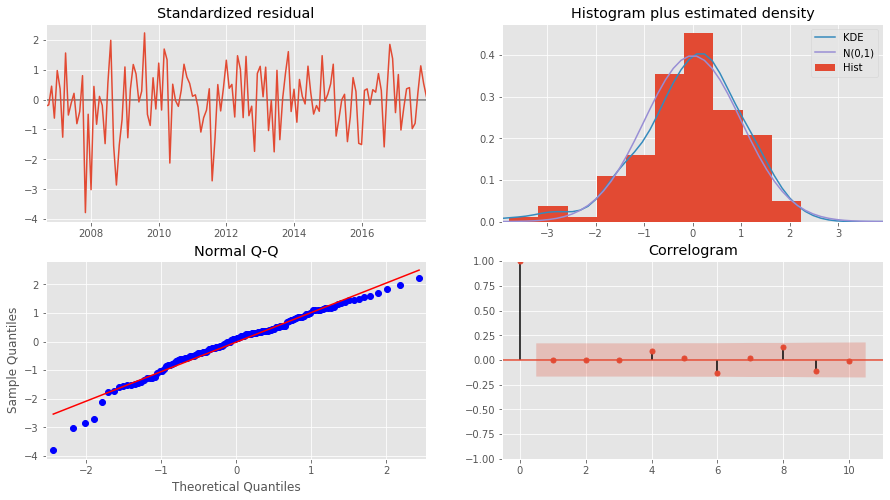

In [41]:
arima_model = sm.tsa.statespace.SARIMAX(RHP_train,
                                        exog = exog_train,
                                        order = parameters,
                                        seasonal_order = seasonal_parameters,
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print('Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

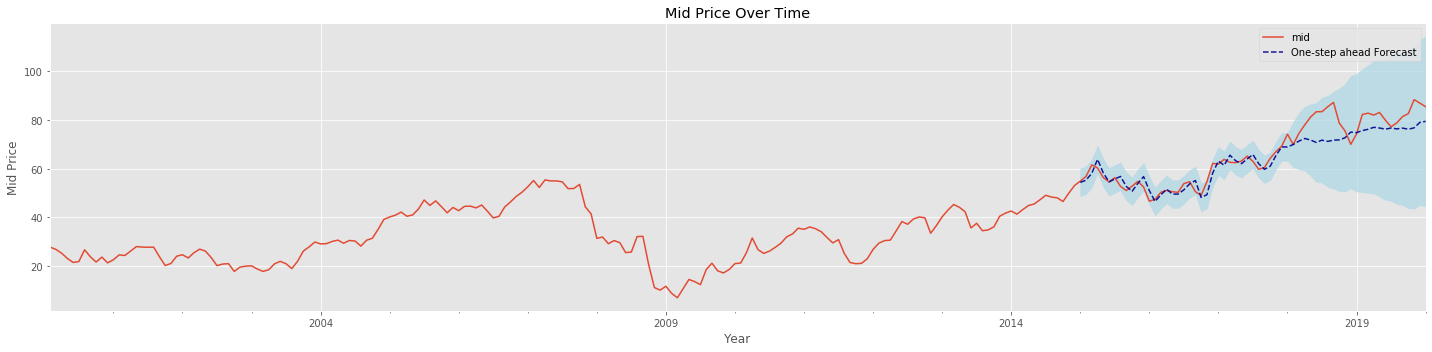

In [55]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = RHP['2000-01-01':].plot(label='observed', figsize = (20,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    